In [1]:
from ambientperiod.builder.build_period import BuildPeriod
import pandas as pd

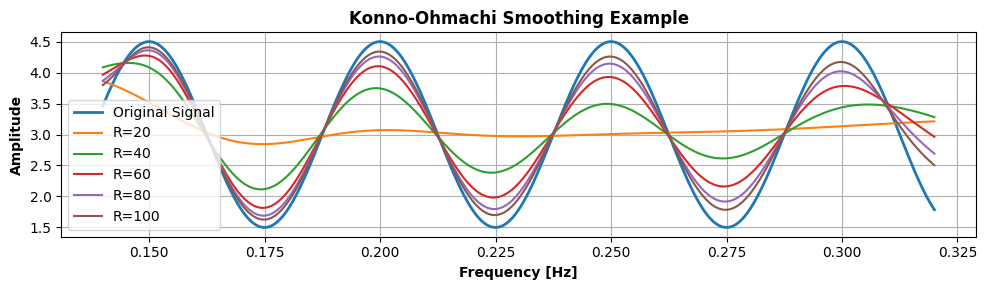

In [2]:
from ambientperiod.analysis.sua_vent import show_smoothing_example

show_smoothing_example()


In [3]:
import matplotlib.pyplot as plt

# Set the font family and size
plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.size'] = 10 
plt.rcParams['font.stretch'] = 'condensed'

In [4]:
# Configuration (defined here instead of a config.py)
config = {
    "Fs": 244,                          # % Frecuencia de muestreo
    "vent": 30,                         # % Duracion de las ventanas
    "STA": 1,       "LTA": 30,          # % Algoritmo STA/LTA
    "vmin": 0.1,    "vmax": 2.5,        # % Limites algoritmo STA/LTA
    "p": 0.05,                          # % R para tapper de ventana
    "f1": 1.0,      "f2": 50.0,         # % Límites de ancho de banda de frecuencia     
    "bexp": 40                          # % Constante de suavizado (Konno & Ohmachi 1998)
}

In [5]:
# signal_path = r'C:\Users\ppala\OneDrive\01. Brain\11. GitHub\AmbientSoilPeriod\signals\TS01.txt'
# builder = BuildPeriod(signal_path, config , display_figures=False)

In [6]:
# signal_path = r'C:\Users\ppala\OneDrive\01. Brain\11. GitHub\AmbientSoilPeriod\signals\Suelo02_Ax01.txt'
# builder_X = BuildPeriod(signal_path, config , display_figures=True)

# signal_path = r'C:\Users\ppala\OneDrive\01. Brain\11. GitHub\AmbientSoilPeriod\signals\Suelo02_Ay01.txt'
# builder_Y = BuildPeriod(signal_path, config , display_figures=True)

# signal_path = r'C:\Users\ppala\OneDrive\01. Brain\11. GitHub\AmbientSoilPeriod\signals\Suelo02_Az01.txt'
# builder_Z = BuildPeriod(signal_path, config , display_figures=True)


--------------------------------------------------
INICIALIZATION
--------------------------------------------------
Signal provided directly as array.
algorithm_sta_lta OK...


C:\Users\ppala\AppData\Local\Temp\ipykernel_81904\609604401.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(r'C:\Users\ppala\OneDrive\01. Brain\10. Ph.D U ANDES\04. Clases\00. U Chile\CI7411 DinamicaSuelos\tarea-CI7411-master\sismos\98-10-16\98-10-16-sup-ns.txt', delim_whitespace=True, header=None, skiprows=1)


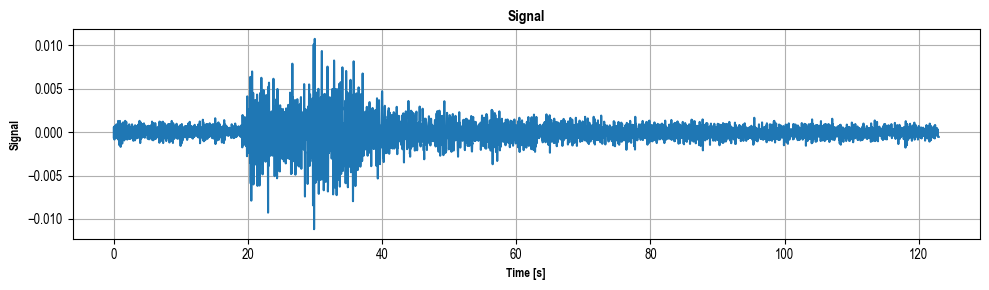

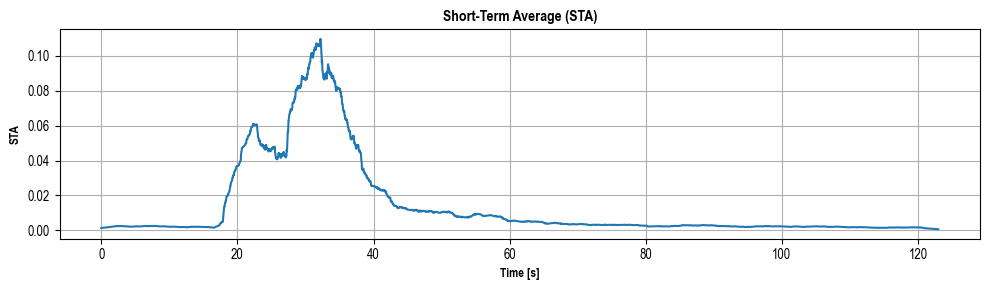

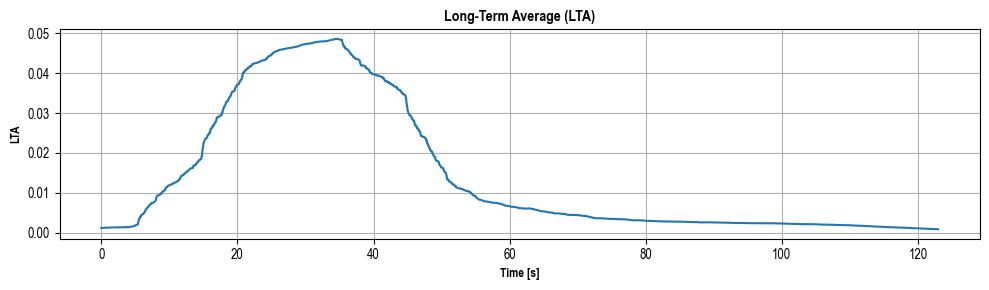

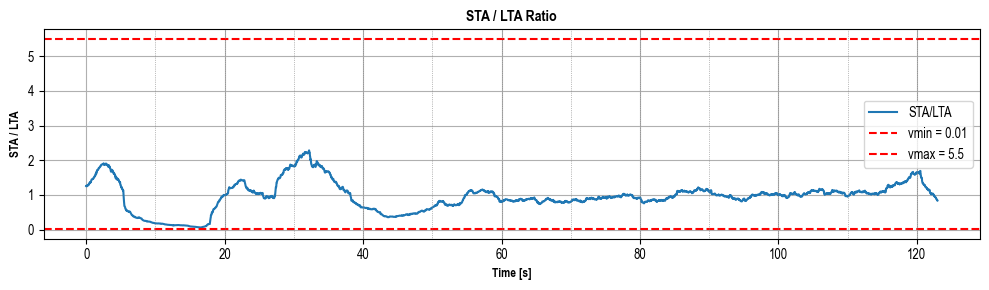

plot_sta_lta OK...
window_selector OK...


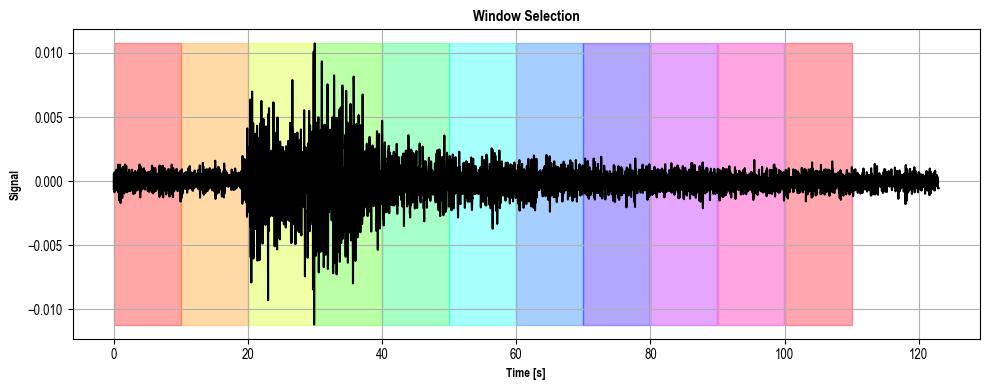

plot_selected_windows OK...
taper_function OK...
plot_tapper OK...
compute_fft OK...
sua_vent OK...
prom_vent OK...


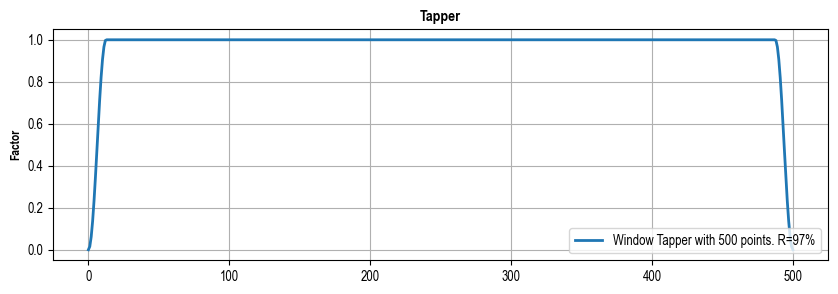

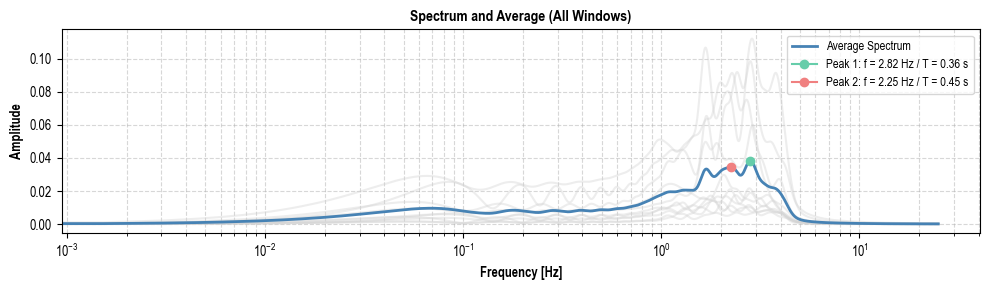

prom_vent OK...
--------------------------------------------------
INICIALIZATION
--------------------------------------------------
Signal provided directly as array.
algorithm_sta_lta OK...


C:\Users\ppala\AppData\Local\Temp\ipykernel_81904\609604401.py:21: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(r'C:\Users\ppala\OneDrive\01. Brain\10. Ph.D U ANDES\04. Clases\00. U Chile\CI7411 DinamicaSuelos\tarea-CI7411-master\sismos\98-10-16\98-10-16-sup-ew.txt', delim_whitespace=True, header=None, skiprows=1)


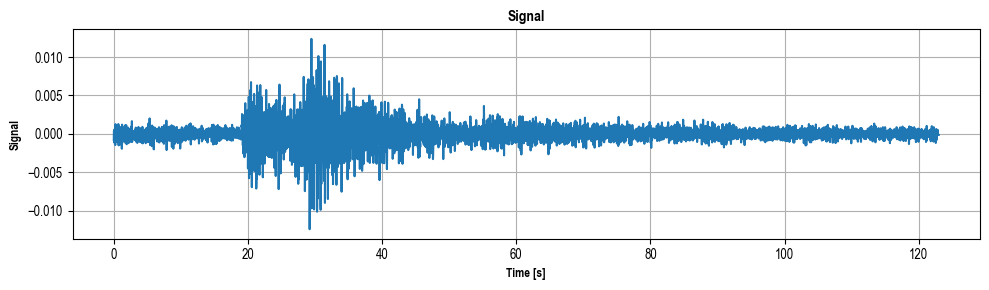

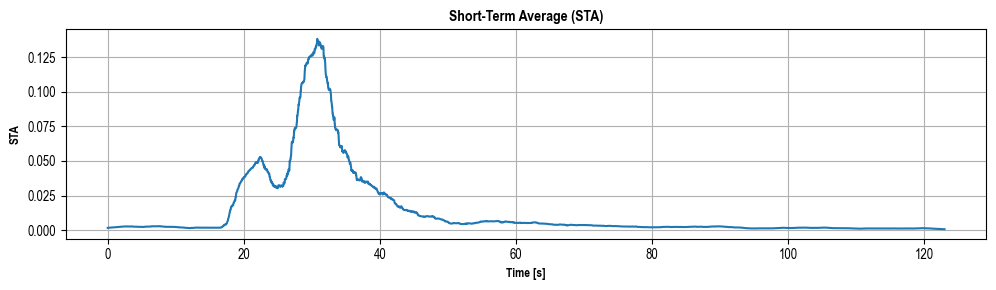

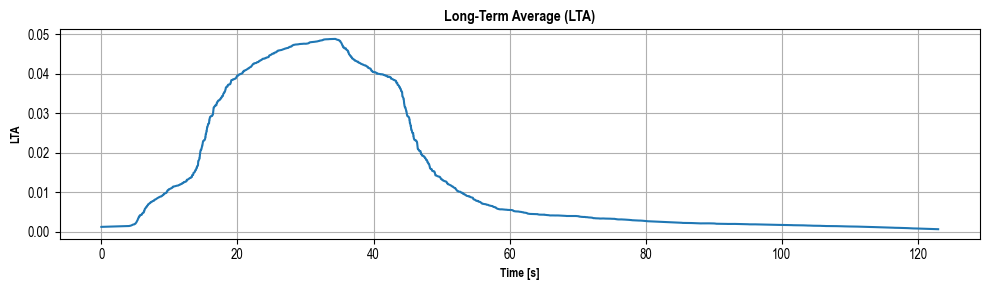

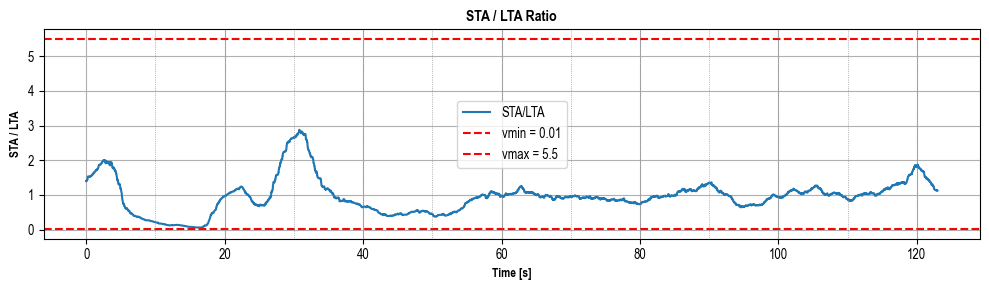

plot_sta_lta OK...
window_selector OK...


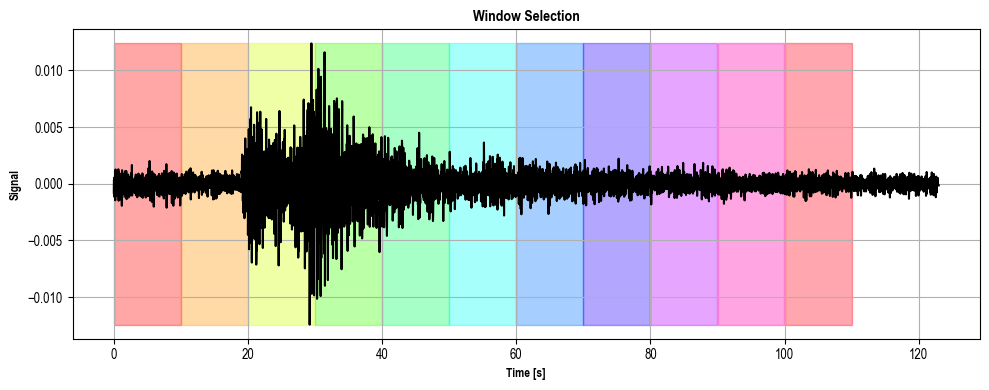

plot_selected_windows OK...
taper_function OK...
plot_tapper OK...
compute_fft OK...
sua_vent OK...
prom_vent OK...


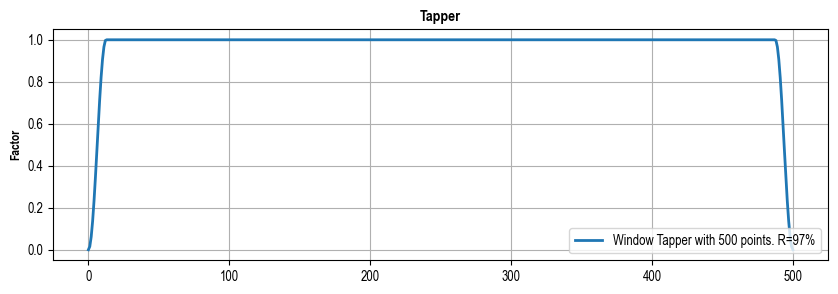

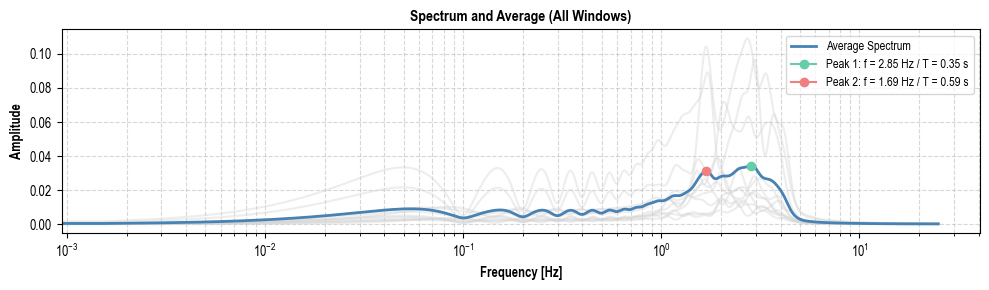

prom_vent OK...
--------------------------------------------------
INICIALIZATION
--------------------------------------------------
Signal provided directly as array.
algorithm_sta_lta OK...


C:\Users\ppala\AppData\Local\Temp\ipykernel_81904\609604401.py:28: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(r'C:\Users\ppala\OneDrive\01. Brain\10. Ph.D U ANDES\04. Clases\00. U Chile\CI7411 DinamicaSuelos\tarea-CI7411-master\sismos\98-10-16\98-10-16-sup-z.txt', delim_whitespace=True, header=None, skiprows=1)


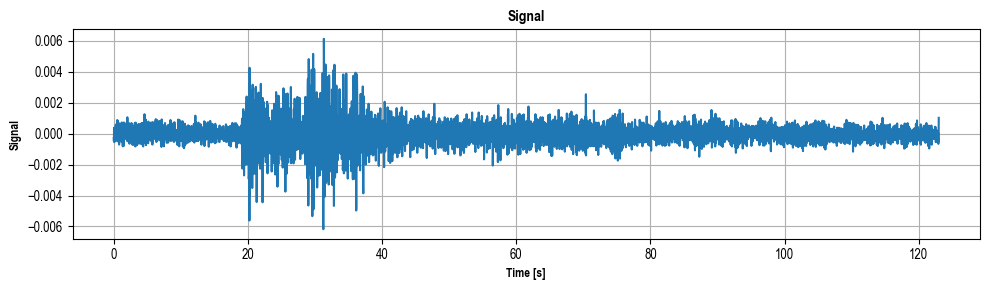

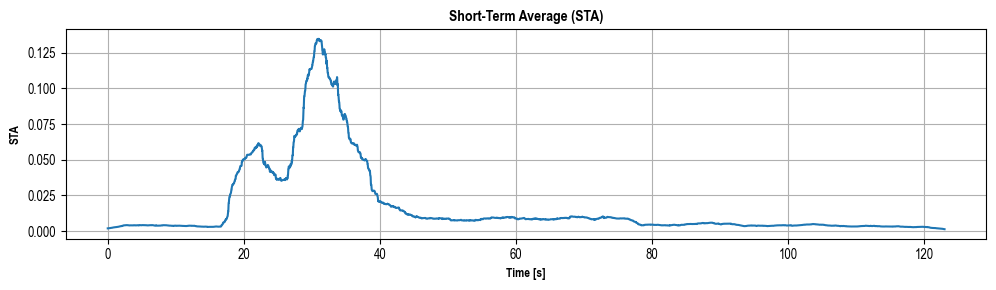

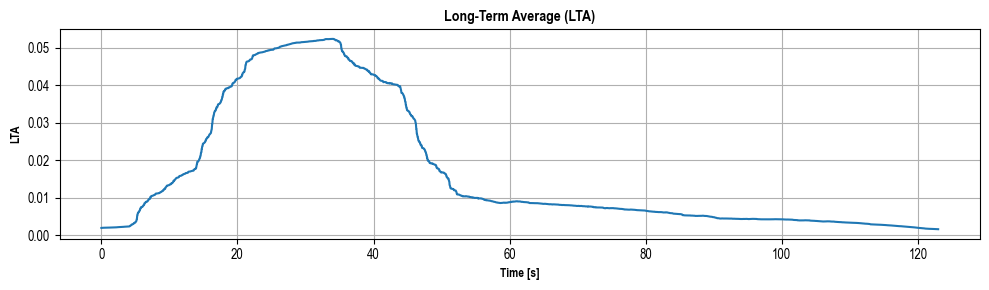

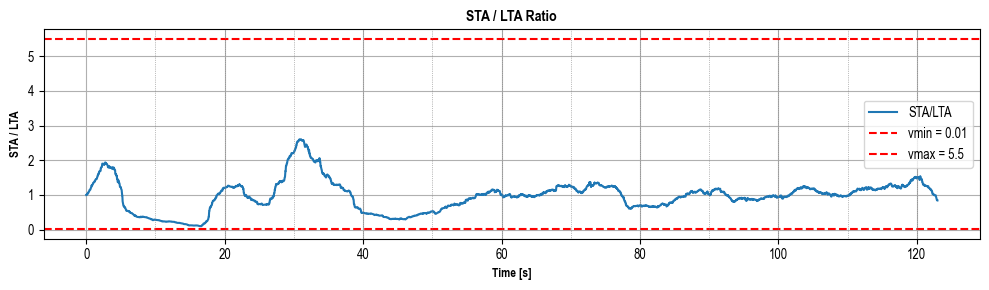

plot_sta_lta OK...
window_selector OK...


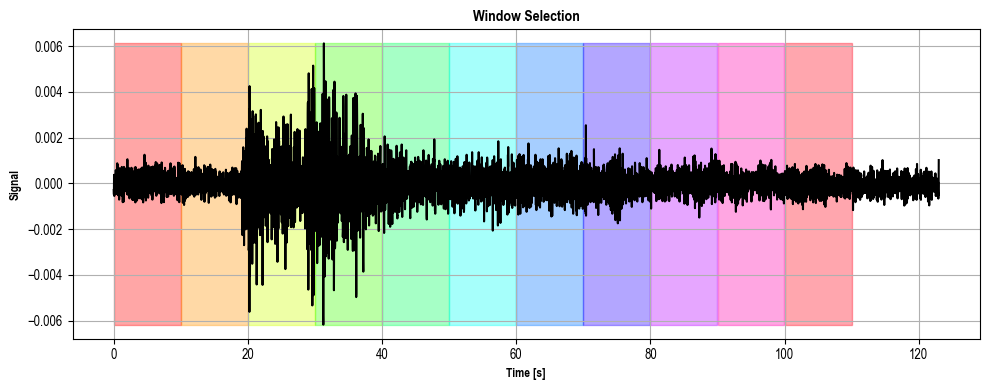

plot_selected_windows OK...
taper_function OK...
plot_tapper OK...
compute_fft OK...
sua_vent OK...
prom_vent OK...


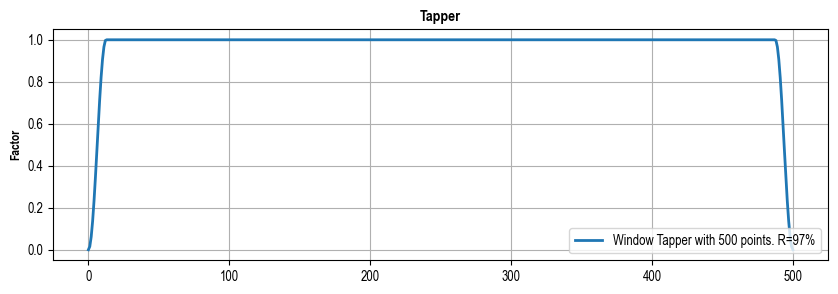

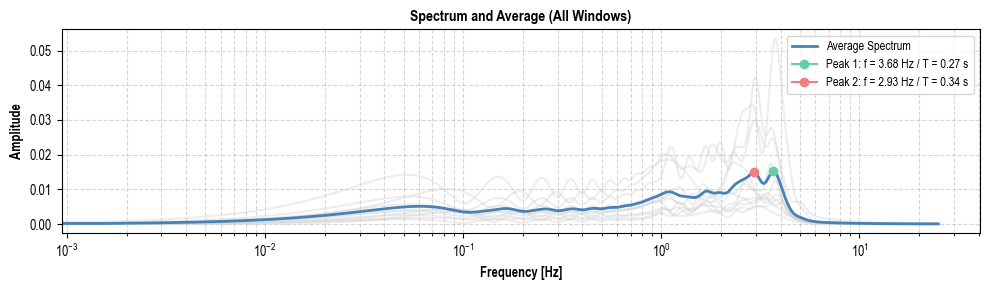

prom_vent OK...


In [7]:
# Configuration (defined here instead of a config.py)
config = {
    "Fs": 1/0.02,                          # % Frecuencia de muestreo
    "vent": 10,                         # % Duracion de las ventanas
    "STA": 5,       "LTA": 30,          # % Algoritmo STA/LTA
    "vmin": 0.01,    "vmax": 5.5,        # % Limites algoritmo STA/LTA
    "p": 0.05,                          # % R para tapper de ventana
    "f1": 1.0,      "f2": 4.0,         # % Límites de ancho de banda de frecuencia     
    "bexp": 40                          # % Constante de suavizado (Konno & Ohmachi 1998)
}



df = pd.read_csv(r'C:\Users\ppala\OneDrive\01. Brain\10. Ph.D U ANDES\04. Clases\00. U Chile\CI7411 DinamicaSuelos\tarea-CI7411-master\sismos\98-10-16\98-10-16-sup-ns.txt', delim_whitespace=True, header=None, skiprows=1)
signal_path = df[1].values

builder_X = BuildPeriod(signal_path, config , display_figures=True)



df = pd.read_csv(r'C:\Users\ppala\OneDrive\01. Brain\10. Ph.D U ANDES\04. Clases\00. U Chile\CI7411 DinamicaSuelos\tarea-CI7411-master\sismos\98-10-16\98-10-16-sup-ew.txt', delim_whitespace=True, header=None, skiprows=1)
signal_path = df[1].values
builder_Y = BuildPeriod(signal_path, config , display_figures=True)




df = pd.read_csv(r'C:\Users\ppala\OneDrive\01. Brain\10. Ph.D U ANDES\04. Clases\00. U Chile\CI7411 DinamicaSuelos\tarea-CI7411-master\sismos\98-10-16\98-10-16-sup-z.txt', delim_whitespace=True, header=None, skiprows=1)
signal_path = df[1].values
builder_Z = BuildPeriod(signal_path, config , display_figures=True)


Text(0.5, 1.0, 'H/V Relation')

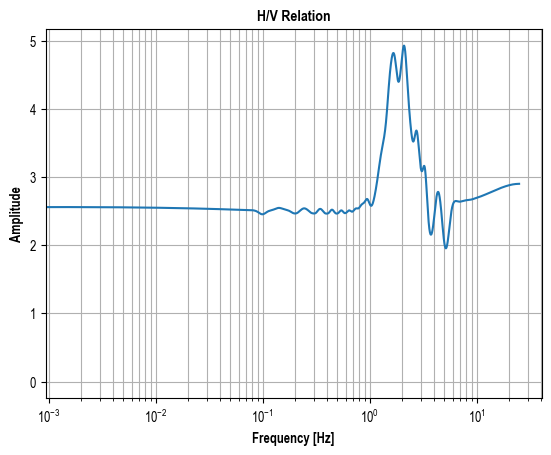

In [8]:
import numpy as np

epsilon = 1e-10  # Pequeño valor para evitar división por cero
NAKAMURA = np.sqrt(builder_X.mean_spectrum**2 + builder_Y.mean_spectrum**2) / (builder_Z.mean_spectrum + epsilon)


plt.semilogx(builder_X.mfx[:, 0] , NAKAMURA)

plt.grid(True, which='both', axis='both')
plt.xlabel('Frequency [Hz]', fontsize=10, fontweight='bold')
plt.ylabel('Amplitude', fontsize=10, fontweight='bold')
plt.title('H/V Relation', fontsize=11, fontweight='bold')



Processing record 1...


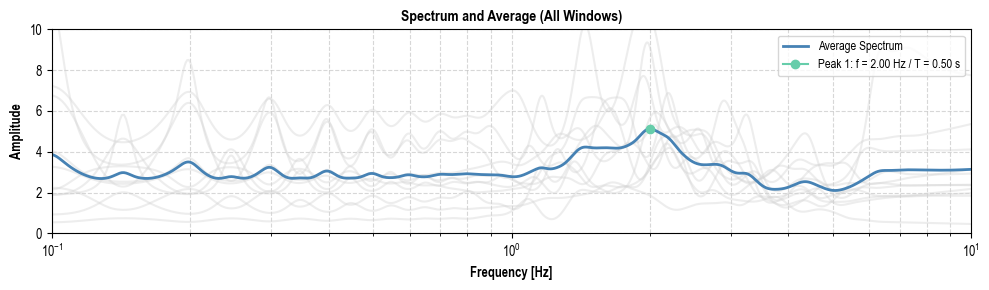

In [9]:
from ambientperiod.tools.plot_spectrum import plot_spectrum

epsilon = 1e-10  # Para evitar división por cero

builders = [
    (builder_X, builder_Y, builder_Z),
]

for idx, (bx, by, bz) in enumerate(builders):
    print(f'Processing record {idx+1}...')

    # --- Frecuencias ---
    mfx = bx.mfx
    if mfx.ndim == 2:
        mfx = mfx[:, 0]

    n_windows = bx.mfs.shape[1]
    nakamura_windows = np.zeros_like(bx.mfs)

    for i in range(n_windows):
        h1 = bx.mfs[:, i]
        h2 = by.mfs[:, i]
        v  = bz.mfs[:, i]
        nakamura_windows[:, i] = np.sqrt(h1**2 + h2**2) / (v + epsilon)


    nakamura_mean = np.mean(nakamura_windows, axis=1)
    peak_spacing_hz = 0.2
    plot_spectrum(mfx, nakamura_windows, nakamura_mean, peak_spacing_hz=peak_spacing_hz , numer_peaks=1 , xlim=[1e-1 , 10], ylim=[0,10])
